# Initial analysis

We want to see how "wide" the uncertainty distributions in `ecoinvent 3.6 (cutoff system model)` are, and whether these values are reasonable.


We start by importing the necessary libraries, and switching to the Brightway project that was set up in notebook 1.

In [1]:
%matplotlib inline

In [2]:
import seaborn as sb
import matplotlib.pyplot as plt

In [3]:
import bw2data as bwd
import bw_processing as bwp
import stats_arrays as sa
import pandas as pd
import numpy as np

In [4]:
bwd.projects.set_current("OASES uncertainty review")

In [5]:
db = bwd.Database("ecoinvent 3.6 cutoff")

Let's get some statistics on the number of exchanges, and their frequency, in both the technosphere and biosphere matrices.

In [6]:
package = bwp.load_package(db.filepath_processed())
technosphere_array = package['technosphere_matrix.npy']
biosphere_array = package['biosphere_matrix.npy']

In [7]:
def get_statistics(array):
    return pd.DataFrame([
        {
            'name': sa.uncertainty_choices[i].description, 
            'id': i,
            'count': (array['uncertainty_type'] == i).sum()
        }
        for i in np.unique(technosphere_array['uncertainty_type'])
    ]).set_index('name')

In [8]:
get_statistics(technosphere_array)

,id,count
name,,
Undefined or unknown uncertainty,0,45906
Lognormal uncertainty,2,162184
Normal uncertainty,3,1
Uniform uncertainty,4,1
Triangular uncertainty,5,115


In [9]:
get_statistics(biosphere_array)

,id,count
name,,
Undefined or unknown uncertainty,0,192944
Lognormal uncertainty,2,213931
Normal uncertainty,3,500
Uniform uncertainty,4,0
Triangular uncertainty,5,62


Our main emphasis will be on the lognormal distribution, but let's make sure the normal and triangular values are reasonable.

# Utility function to look up exchanges

In [10]:
def label_exchanges(array):
    rm = {j: i for i, j in bwd.mapping.items()}
    inputs = [bwd.get_activity(rm[i]) for i in array['row_value']]
    outputs = [bwd.get_activity(rm[i]) for i in array['col_value']]
    return pd.DataFrame([{
        'input name': i['name'],
        'input location': i.get('location'),
        'input unit': i['unit'],
        'output name': o['name'],
        'output location': o.get('location'),
        'output unit': o['unit'],
        'amount': r['amount'],
        'minimum': r['minimum'],
        'maximum': r['maximum'],
        'scale': r['scale'],
        'shape': r['shape']
    } for i, o, r in zip(inputs, outputs, array)])

# Triangular distributions

In [11]:
all_array = np.hstack([technosphere_array, biosphere_array])
all_array.shape

(615644,)

In [12]:
triangular = all_array[all_array['uncertainty_type'] == sa.TriangularUncertainty.id]

## Ratio of mode to mean and medium

Text(0, 0.5, 'probability')

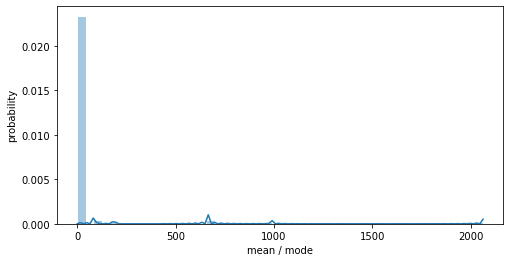

In [13]:
ratio_mean = (triangular['maximum'] + triangular['minimum'] + triangular['loc']) / 3 / triangular['loc']
plt.figure(figsize=(8, 4))
sb.distplot(ratio_mean)
plt.xlabel("mean / mode")
plt.ylabel("probability")

Text(0, 0.5, 'probability')

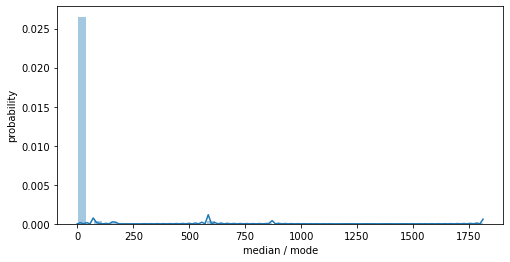

In [14]:
ratio_mean = sa.TriangularUncertainty.ppf(triangular, np.ones(triangular.shape) * 0.5).ravel() / triangular['loc']
plt.figure(figsize=(8, 4))
sb.distplot(ratio_mean)
plt.xlabel("median / mode")
plt.ylabel("probability")

# Look into high values

In [15]:
mask = ((triangular['maximum'] + triangular['minimum'] + triangular['loc']) / 3 / triangular['loc']) > 25
label_exchanges(triangular[mask])

,input name,input location,input unit,output name,output location,output unit,amount,minimum,maximum,scale,shape
0,"market for chemical, organic",GLO,kilogram,"tissue paper production, virgin",GLO,kilogram,1.000000e-03,0.000000e+00,2.000000e+00,NaN,NaN
1,"market for rosin size, for paper production",RER,kilogram,"tissue paper production, virgin",GLO,kilogram,1.293623e-02,0.000000e+00,8.000000e+01,NaN,NaN
2,"market for sodium hydroxide, without water, in...",GLO,kilogram,"treatment of sulfidic tailing, off-site, high ...",ZA,kilogram,2.143470e+03,8.304100e+02,1.192920e+06,NaN,NaN
3,"market for rosin size, for paper production",RoW,kilogram,"tissue paper production, virgin",GLO,kilogram,2.706377e-02,0.000000e+00,8.000000e+01,NaN,NaN
4,"market for chemicals, inorganic",GLO,kilogram,"tissue paper production, virgin",GLO,kilogram,1.000000e-02,0.000000e+00,2.000000e+01,NaN,NaN
5,"Transformation, from unspecified",None,square meter,"mine construction, gold",ZA,unit,6.780000e+07,1.300000e+07,1.740000e+10,NaN,NaN
6,"Transformation, to unspecified",None,square meter,"mine construction, gold",ZA,unit,6.780000e+07,1.300000e+07,1.740000e+10,NaN,NaN


It is clear that the tissue paper producers have some strange values (80 kg of rosin paper for 1 kg of tissue paper), but this should not effect our results.

# Normal distribution

In [16]:
normal = all_array[all_array['uncertainty_type'] == sa.NormalUncertainty.id]

## Ratio of mode to mean

/Users/cmutel/miniconda3/envs/bw2dev/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'probability')

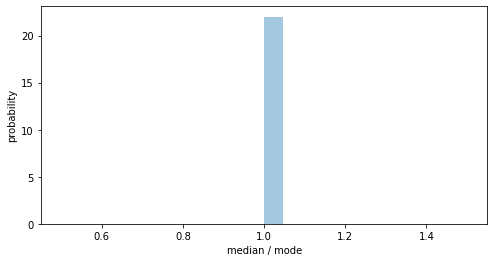

In [17]:
ratio_mean = sa.NormalUncertainty.ppf(normal, np.ones(normal.shape) * 0.5).ravel() / normal['loc']
plt.figure(figsize=(8, 4))
sb.distplot(ratio_mean)
plt.xlabel("median / mode")
plt.ylabel("probability")

All median values are correctly the same as mean (and mode).

What about the chance that a given exchange is negative?

Text(0, 0.5, 'probability')

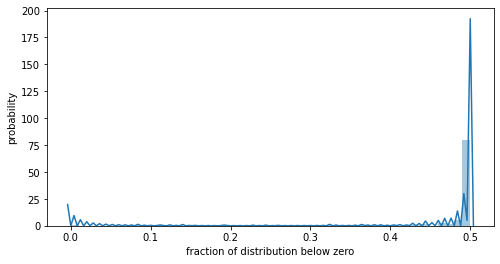

In [18]:
ratio_mean = sa.NormalUncertainty.cdf(normal, np.zeros(normal.shape)).ravel()
plt.figure(figsize=(8, 4))
sb.distplot(ratio_mean)
plt.xlabel("fraction of distribution below zero")
plt.ylabel("probability")

There are a lot of distributions where zero has a high probability of occurring. How many exactly?

In [19]:
(sa.NormalUncertainty.cdf(normal, np.zeros(normal.shape)).ravel() > 0.25).sum()

485

In [20]:
mask = (sa.NormalUncertainty.cdf(normal, np.zeros(normal.shape)).ravel() > 0.25)
labelled = label_exchanges(normal[mask])
labelled

,input name,input location,input unit,output name,output location,output unit,amount,minimum,maximum,scale,shape
0,Cadmium,None,kilogram,fattening of heifers for beef cattle productio...,RoW,kilogram,0.000095,NaN,NaN,0.307571,NaN
1,Cadmium,None,kilogram,beef cattle production on pasture and proteic ...,RoW,kilogram,0.000352,NaN,NaN,0.307571,NaN
2,Cadmium,None,kilogram,"intensive beef cattle production, fat steers o...",BR,kilogram,0.000168,NaN,NaN,0.307571,NaN
3,Cadmium,None,kilogram,beef cattle production on pasture and proteic ...,BR,kilogram,0.000327,NaN,NaN,0.307571,NaN
4,Cadmium,None,kilogram,beef cattle production on pasture and feedlot,RoW,kilogram,0.000150,NaN,NaN,0.307571,NaN
...,...,...,...,...,...,...,...,...,...,...,...
480,"Carbon dioxide, from soil or biomass stock",None,kilogram,fennel production,GLO,kilogram,0.054578,NaN,NaN,0.738377,NaN
481,"Carbon dioxide, from soil or biomass stock",None,kilogram,"strawberry production, open field, macro tunnel",RoW,kilogram,0.003314,NaN,NaN,0.738377,NaN
482,"Carbon dioxide, from soil or biomass stock",None,kilogram,iceberg lettuce production,GLO,kilogram,0.007256,NaN,NaN,0.738377,NaN
483,"Carbon dioxide, from soil or biomass stock",None,kilogram,"coconut production, dehusked",RoW,kilogram,0.103189,NaN,NaN,0.738377,NaN


In [21]:
labelled['input name'].value_counts()

Lead                                          69
Carbon dioxide, from soil or biomass stock    48
Chromium                                      44
Copper                                        38
Nickel                                        38
Zinc, ion                                     37
Copper, ion                                   36
Nickel, ion                                   35
Cadmium, ion                                  33
Cadmium                                       33
Chromium, ion                                 33
Zinc                                          33
Mercury                                        7
Water                                          1
Name: input name, dtype: int64

In [22]:
labelled['output name'].value_counts()

intensive beef cattle production on pasture                      72
intensive beef cattle production, fat steers only, on pasture    48
beef cattle production on pasture and feedlot                    48
beef cattle production on pasture and proteic supplement         48
weaned calves production on pasture                              36
                                                                 ..
apple production                                                  1
grape production                                                  1
cauliflower production                                            1
cucumber production                                               1
lettuce361 production                                             1
Name: output name, Length: 66, dtype: int64

I don't see how these values could be physically negative; therefore, we should limit them to be greater than or equal to zero.

In the longer term, these high uncertainties should be better characterized.